<a href="https://colab.research.google.com/github/deveshsingh14/Stock-Market-Analysis-and-Prediction-using-LSTM/blob/main/ACE_LSTM_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0403 - val_loss: 0.0040
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 1

<ipython-input-2-bced6ba89608>:82: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month_data = ohlc_data.last('1M')
<ipython-input-2-bced6ba89608>:82: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last_month_data = ohlc_data.last('1M')


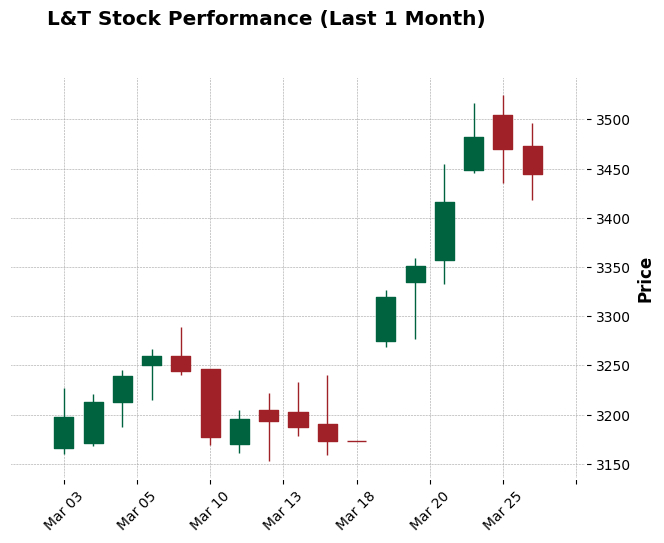

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mplfinance as mpf
from datetime import datetime

# Download data
end = datetime.now()
start = datetime(2020, 1, 1)
data = yf.download('LT.NS', start=start, end=end)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Normalize Prices and Volume Separately
scaler_price = MinMaxScaler()
scaler_volume = MinMaxScaler()

data_scaled = data.copy()
data_scaled[['Open', 'High', 'Low', 'Close']] = scaler_price.fit_transform(data[['Open', 'High', 'Low', 'Close']])
data_scaled[['Volume']] = scaler_volume.fit_transform(data[['Volume']])
data_scaled = data_scaled.values  # Convert to numpy array

# Prepare the dataset
X = []
y = []
TIME_STEP = 60

for i in range(TIME_STEP, len(data_scaled)):
    X.append(data_scaled[i - TIME_STEP:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the updated LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(100, return_sequences=False),
    Dropout(0.1),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(5, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict the test set
predictions = model.predict(X_test)
predictions[:, :4] = scaler_price.inverse_transform(predictions[:, :4])
predictions[:, 4] = scaler_volume.inverse_transform(predictions[:, 4].reshape(-1, 1)).flatten()
y_test[:, :4] = scaler_price.inverse_transform(y_test[:, :4])
y_test[:, 4] = scaler_volume.inverse_transform(y_test[:, 4].reshape(-1, 1)).flatten()

# Predict the next day
last_sequence = data_scaled[-TIME_STEP:].reshape(1, TIME_STEP, 5)
next_day_scaled = model.predict(last_sequence)
next_day = np.zeros((1, 5))
next_day[:, :4] = scaler_price.inverse_transform(next_day_scaled[:, :4])
next_day[:, 4] = scaler_volume.inverse_transform(next_day_scaled[:, 4].reshape(-1, 1)).flatten()
print(f"Predicted values for next day: {next_day}")

# Prepare OHLC data for candlestick plotting
ohlc_data = pd.DataFrame({
    'Open': data['Open'].values.flatten(),
    'High': data['High'].values.flatten(),
    'Low': data['Low'].values.flatten(),
    'Close': data['Close'].values.flatten()
}, index=data.index)

# Plot last 1 month dataset as candlestick chart
last_month_data = ohlc_data.last('1M')
mpf.plot(last_month_data, type='candle', style='charles', title='L&T Stock Performance (Last 1 Month)', ylabel='Price')

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# Compute accuracy for each parameter
accuracy_open = 100 - mean_absolute_percentage_error(y_test[:, 0], predictions[:, 0]) * 100
accuracy_high = 100 - mean_absolute_percentage_error(y_test[:, 1], predictions[:, 1]) * 100
accuracy_low = 100 - mean_absolute_percentage_error(y_test[:, 2], predictions[:, 2]) * 100
accuracy_close = 100 - mean_absolute_percentage_error(y_test[:, 3], predictions[:, 3]) * 100
accuracy_volume = 100 - mean_absolute_percentage_error(y_test[:, 4], predictions[:, 4]) * 100

# Print the accuracies
print(f"Model accuracy for Open: {accuracy_open:.2f}%")
print(f"Model accuracy for High: {accuracy_high:.2f}%")
print(f"Model accuracy for Low: {accuracy_low:.2f}%")
print(f"Model accuracy for Close: {accuracy_close:.2f}%")
print(f"Model accuracy for Volume: {accuracy_volume:.2f}%")


Model accuracy for Open: 99.16%
Model accuracy for High: 99.00%
Model accuracy for Low: 98.87%
Model accuracy for Close: 98.56%
Model accuracy for Volume: -3432024391033028608000.00%


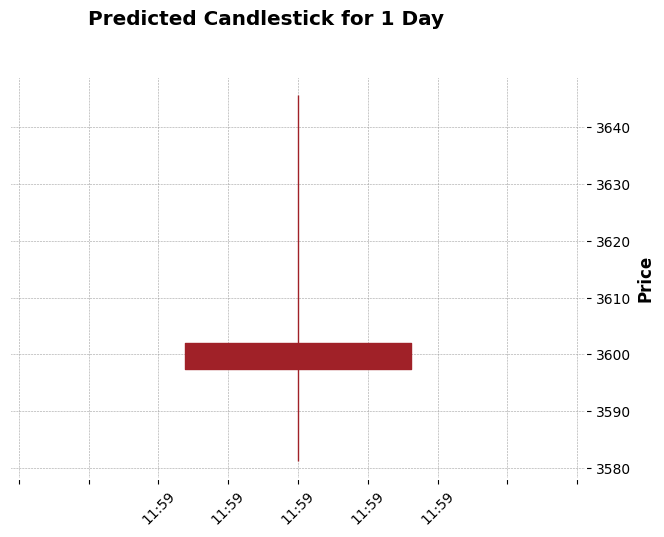

In [ ]:
import pandas as pd
import mplfinance as mpf
import datetime

# Create DataFrame for the predicted values
predicted_ohlc = pd.DataFrame({
    'Date': [datetime.datetime.now()],  # Use current date for the prediction
    'Open': predictions[0, 0],
    'High': predictions[0, 1],
    'Low': predictions[0, 2],
    'Close': predictions[0, 3],
    'Volume': predictions[0, 4]
})

# Convert Date column to datetime index
predicted_ohlc.set_index('Date', inplace=True)

# Plot the candlestick chart
mpf.plot(predicted_ohlc, type='candle', style='charles', title='Predicted Candlestick for 1 Day', ylabel='Price')


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluate accuracy for all five parameters
metrics = ['Open', 'High', 'Low', 'Close', 'Volume']
mape_values = []
rmse_values = []
mae_values = []

for i, metric in enumerate(metrics):
    mape = mean_absolute_percentage_error(y_test[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])

    mape_values.append(mape)
    rmse_values.append(rmse)
    mae_values.append(mae)

    print(f"{metric} - MAPE: {mape:.2f}%, RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Open - MAPE: 0.84%, RMSE: 39.97, MAE: 30.06
High - MAPE: 1.00%, RMSE: 49.34, MAE: 35.77
Low - MAPE: 1.13%, RMSE: 61.07, MAE: 39.36
Close - MAPE: 1.44%, RMSE: 68.67, MAE: 51.14
Volume - MAPE: inf%, RMSE: 1499289.94, MAE: 878904.13


<ipython-input-5-5a254dd8d717>:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for each parameter
rmse_values = np.sqrt(mean_squared_error(y_test, predictions, multioutput='raw_values'))

# Calculate accuracy in percentage
accuracy = (1 - (rmse_values / np.abs(y_test.mean(axis=0)))) * 100

# Print accuracy for each parameter
metrics = ['Open', 'High', 'Low', 'Close', 'Volume']
for i, metric in enumerate(metrics):
    print(f"Model accuracy for {metric}: {accuracy[i]:.2f}%")


Model accuracy for Open: 98.88%
Model accuracy for High: 98.63%
Model accuracy for Low: 98.26%
Model accuracy for Close: 98.07%
Model accuracy for Volume: 38.86%


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for each parameter
mae_values = mean_absolute_error(y_test, predictions, multioutput='raw_values')

# Calculate accuracy in percentage
accuracy = (1 - (mae_values / np.abs(y_test.mean(axis=0)))) * 100

# Print accuracy for each parameter
metrics = ['Open', 'High', 'Low', 'Close', 'Volume']
for i, metric in enumerate(metrics):
    print(f"Model accuracy for {metric}: {accuracy[i]:.2f}%")


Model accuracy for Open: 99.16%
Model accuracy for High: 99.01%
Model accuracy for Low: 98.88%
Model accuracy for Close: 98.56%
Model accuracy for Volume: 64.16%


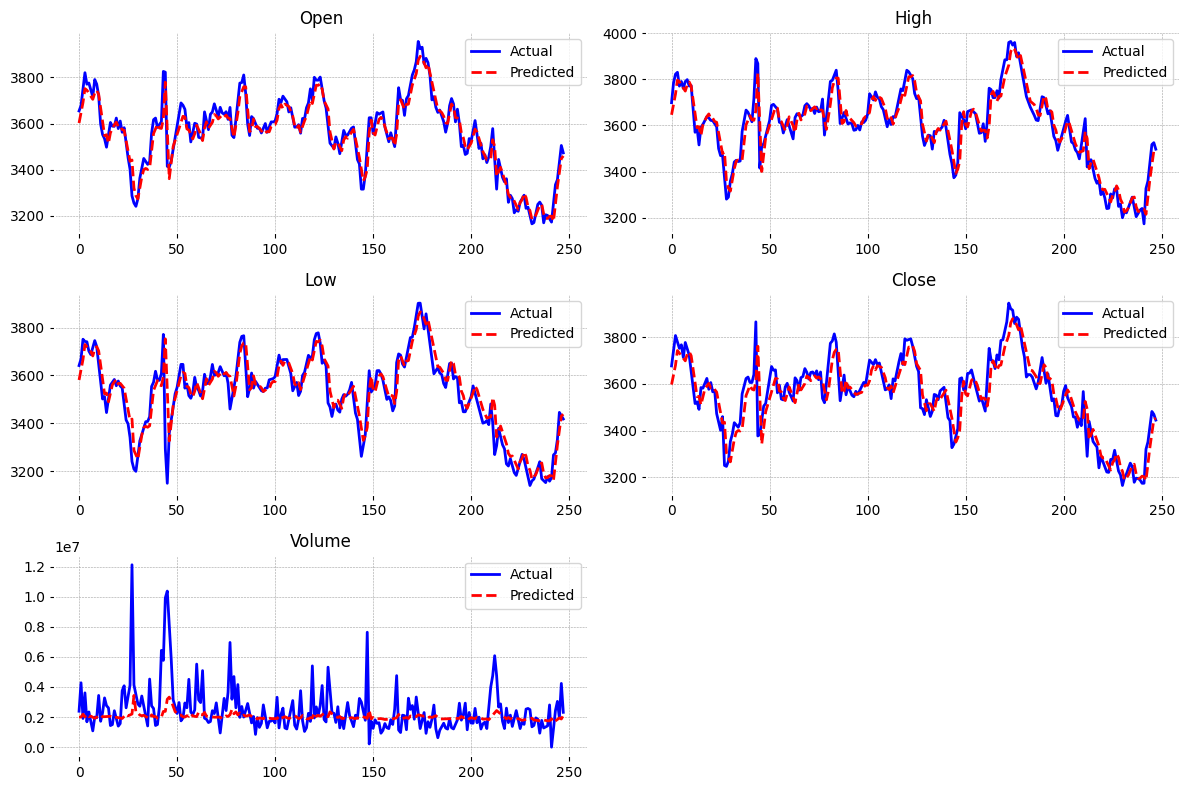

In [ ]:
plt.figure(figsize=(12, 8))
labels = ['Open', 'High', 'Low', 'Close', 'Volume']
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.plot(y_test[:, i], label="Actual", color='blue')
    plt.plot(predictions[:, i], label="Predicted", color='red', linestyle='dashed')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()


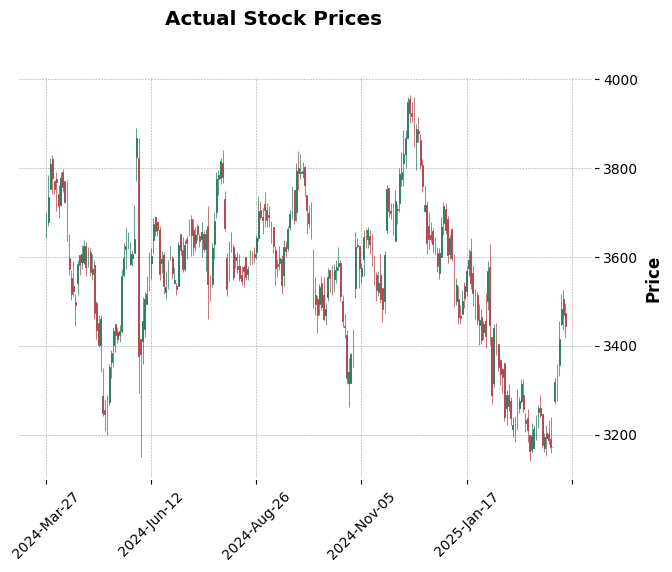

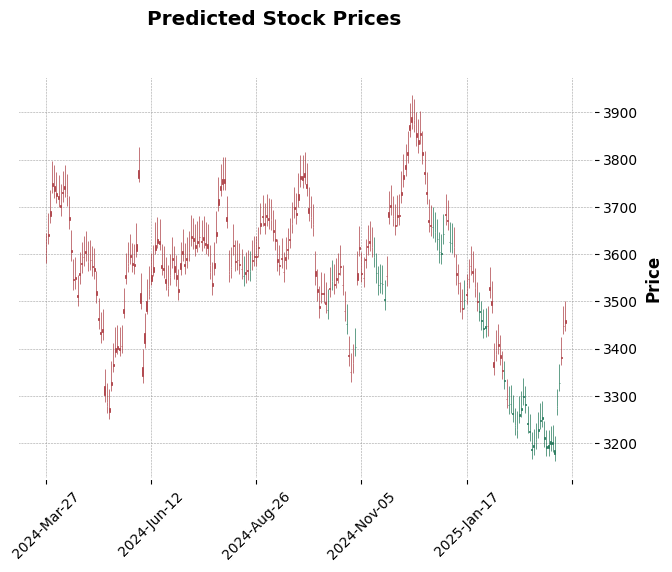

In [ ]:
import pandas as pd
import mplfinance as mpf

# Create DataFrames for actual and predicted values
actual_ohlc = pd.DataFrame({
    'Open': y_test[:, 0],
    'High': y_test[:, 1],
    'Low': y_test[:, 2],
    'Close': y_test[:, 3]
}, index=data.index[-len(y_test):])

predicted_ohlc = pd.DataFrame({
    'Open': predictions[:, 0],
    'High': predictions[:, 1],
    'Low': predictions[:, 2],
    'Close': predictions[:, 3]
}, index=data.index[-len(predictions):])

# Plot actual vs predicted candlestick charts
mpf.plot(actual_ohlc, type='candle', style='charles', title='Actual Stock Prices', ylabel='Price')
mpf.plot(predicted_ohlc, type='candle', style='charles', title='Predicted Stock Prices', ylabel='Price')


<ipython-input-10-c341008b3e88>:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month_actual = ohlc_data.last('1M')
<ipython-input-10-c341008b3e88>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last_month_actual = ohlc_data.last('1M')
<ipython-input-10-c341008b3e88>:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month_predicted = predicted_ohlc.last('1M')
<ipython-input-10-c341008b3e88>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last_month_predicted = predicted_ohlc.last('1M')


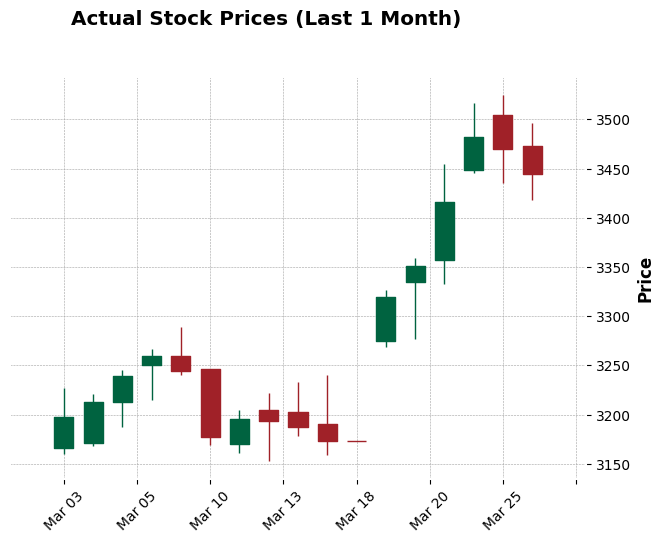

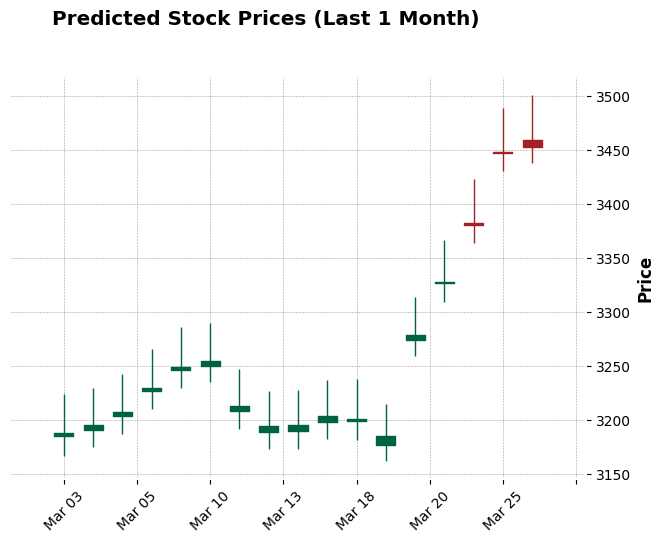

In [ ]:
# Filter last one month's data
last_month_actual = ohlc_data.last('1M')
last_month_predicted = predicted_ohlc.last('1M')

# Plot actual vs predicted candlestick chart for the last 1 month
mpf.plot(last_month_actual, type='candle', style='charles', title='Actual Stock Prices (Last 1 Month)', ylabel='Price')
mpf.plot(last_month_predicted, type='candle', style='charles', title='Predicted Stock Prices (Last 1 Month)', ylabel='Price')
